This is just to demonstrate how the analysis will work for the POC, and also to show what the final exported notebook will look like. When that is implemented, get rid of this!

First, generate a fake dataset. In the future, let's check it in and use it if the [`--demo` flag](https://github.com/opendp/dp-creator-ii/issues/7) is given.

In [76]:
import csv
import random

random.seed(0) # So the mock data will be stable across runs.

def clip(n, lower, upper):
    return max(min(n, upper), lower)

csv_path = '/tmp/demo.csv'

with open(csv_path, 'w', newline='') as demo_handle:
    fields = ['student_id', 'class_year', 'hw_number', 'grade']
    writer = csv.DictWriter(demo_handle, fieldnames=fields)
    writer.writeheader()
    for student_id in range(1, 50):
        class_year = int(clip(random.gauss(2, 1), 1, 4))
        mean_grade = random.gauss(80, 5) + class_year * 2
        for hw_number in range(1, 10):
            grade = int(clip(random.gauss(mean_grade, 5), 0, 100))
            writer.writerow({
                'student_id': student_id,
                'class_year': class_year,
                'hw_number': hw_number,
                'grade': grade,
            })

Sanity check:

In [77]:
import polars

lf = polars.scan_csv(csv_path)
lf.collect()

student_id,class_year,hw_number,grade
i64,i64,i64,i64
1,2,1,73
1,2,2,78
1,2,3,71
1,2,4,76
1,2,5,77
…,…,…,…
49,1,5,89
49,1,6,72
49,1,7,81


TODO: Plot function from in https://github.com/opendp/dp-creator-ii/pull/35... but see farther down in the notebook: This can probably be further simplified.

In [78]:
import matplotlib.pyplot as plt
import numpy as np


def plot_error_bars_with_cutoff(
    y_values, x_min_label="min", x_max_label="max", y_cutoff=0, y_error=0
):
    x_values = 0.5 + np.arange(len(y_values))
    x_values_above = []
    x_values_below = []
    y_values_above = []
    y_values_below = []
    for x, y in zip(x_values, y_values):
        if y < y_cutoff:
            x_values_below.append(x)
            y_values_below.append(y)
        else:
            x_values_above.append(x)
            y_values_above.append(y)

    figure, axes = plt.subplots()
    color = "skyblue"
    shared = {
        "width": 0.8,
        "edgecolor": color,
        "linewidth": 1,
        "yerr": y_error,
    }
    axes.bar(x_values_above, y_values_above, color=color, **shared)
    axes.bar(x_values_below, y_values_below, color="white", **shared)
    axes.hlines([y_cutoff], 0, len(y_values), colors=["black"], linestyles=["dotted"])

    axes.set(xlim=(0, len(y_values)), ylim=(0, max(y_values)))
    axes.get_xaxis().set_ticks(
        ticks=[x_values[0], x_values[-1]],
        labels=[x_min_label, x_max_label],
    )
    axes.get_yaxis().set_ticks([])

In [79]:
class_years = lf.group_by('class_year').len().collect().sort('class_year')
class_years

class_year,len
i64,u32
1,198
2,126
3,81
4,36


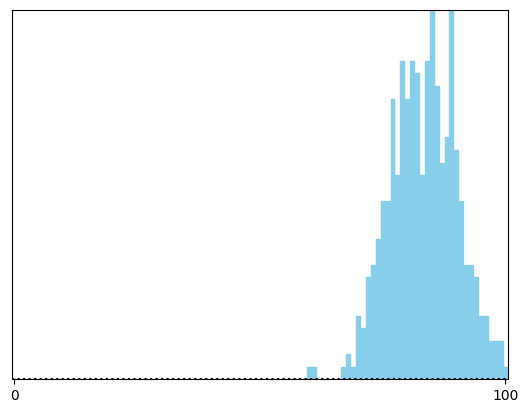

In [80]:
grades = lf.group_by('grade').len().collect().sort('grade')
min_grade = 0
max_grade = 100
df_0_100 = polars.from_dict({'grade': range(min_grade, max_grade+1)})
grades_0_100 = df_0_100.join(grades, on='grade', how='left').select(['len']).fill_null(0)
plot_error_bars_with_cutoff(grades_0_100.to_series().to_list(), min_grade, max_grade)

## _Proposed generated notebook starts below!_

---

# Introduction to Differential Privacy with OpenDP

This notebook will demonstrate how to make a differentially private release with [OpenDP](https://docs.opendp.org) using the data you've provided. The OpenDP API has many more options than we can expose in a UI, and this notebook will suggest some options to explore.

The concept of a privacy budget is important in DP. Interactively developing DP analyses is a good practice, for example, to identify variables of interest before choosing where to spend the rest of a finite privacy budget. That said, it is important to track the total budget consumed: It would not be good to run a cell in this notebook, look at output, and then run it again, without tracking the privacy consumed by each operaion.

We begin with a conventional set of imports:

In [81]:
# Uncomment if you have not already installed OpenDP:
# %pip install opendp==0.11.1

# OpenDP extends the Polars dataframe library:
import polars as pl
# Conventional import for OpenDP:
import opendp.prelude as dp

# OpenDP plans to offer a set algorithms that have been formally reviewed for correctness.
# Until that is complete, we need to opt-in to "contributed" features:
dp.enable_features("contrib")

Next, the information that was provided in the UI:

In [82]:
# Information you've provided that applies to the whole calculation:
csv_path = '/tmp/demo.csv'
contributions = 10
epsilon = 2
weights = [4, 4, 1, 1]
max_possible_rows = 1000000 
delta = 1e-7

# Information you've provided for the "grade" column:
grade_min = 50
grade_max = 100
grade_bins_count = 10

grade_bins_list = list(range(
    grade_min,
    grade_max,
    int((grade_max - grade_min + 1) / grade_bins_count)
))

# Information you've provided for the "class_year" column:
class_year_min = 1
class_year_max = 4
class_year_bins_count = 4

class_year_bins_list = list(range(
    class_year_min,
    class_year_max,
    int((class_year_max - class_year_min + 1) / class_year_bins_count)
))

Finally, define a [`Context`](https://docs.opendp.org/en/stable/api/user-guide/context/index.html) using the provided information.

In [83]:
context = dp.Context.compositor(
    data=pl.scan_csv(csv_path, encoding="utf8-lossy").with_columns(
        # The cut() method returns a Polars categorical type.
        # Cast to string to get the human-readable label.
        pl.col("grade").cut(grade_bins_list).alias("grade_bin").cast(pl.String),
        pl.col("class_year").cut(class_year_bins_list).alias("class_year_bin").cast(pl.String)
    ),
    privacy_unit=dp.unit_of(contributions=contributions),
    privacy_loss=dp.loss_of(epsilon=epsilon, delta=delta),
    split_by_weights=weights,
    margins={
        (): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            # To calculate the mean, we need to know the total number of entries,
            # but this is not by default public information. We must opt-in:
            public_info="lengths",
        ),
        # For the histograms we need more information: The keys we are grouping by.
        ("grade_bin",): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            public_info="keys",
        ),
        ("class_year_bin",): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            public_info="keys",
        ),

    },
)

(A note on `utf8-lossy`: CSVs can use different "character encodings" to represent characters outside the plain ASCII character set, but out of the box the Polars library only supports UTF8. Specifying `utf8-lossy` preserves as much information as possible, and any unrecognized characters will be replaced by "�". If this is not sufficient, you will need to preprocess your data to reencode it as UTF8.)

Before making the DP release, let's define helper functions to render the histograms.

In [84]:
def df_to_dict(df):
    return {
        # The name of the key will vary, so just get the first value.
        list(range_len.values())[0]: range_len['len']
        for range_len in df.to_dicts()
    }

import matplotlib.pyplot as plt

def plot_histogram(histogram_df, error, cutoff):
    # TODO: Error bars
    # TODO: Actually use cutoff
    histogram_dict = df_to_dict(histogram_df)
    labels, values = zip(*histogram_dict.items())
    _figure, axes = plt.subplots()
    axes.bar(labels, values, color=['blue' if v > cutoff else 'lightblue' for v in values])
    axes.axhline(cutoff, color="lightgrey", zorder=-1)

## `grade` stats

In [85]:
grade_mean = context.query().select(
    pl.col("grade").fill_null(0).dp.mean(bounds=(grade_min, grade_max))
).release().collect()
grade_mean

grade
f64
80.510204


In [86]:
grade_histogram = (context.query()
        .group_by("grade_bin")
        .agg(pl.len().dp.noise())
        .release()
        .collect()
        .sort("grade_bin")
)
grade_histogram

grade_bin,len
str,u32
"""(55, 60]""",40
"""(60, 65]""",6
"""(65, 70]""",19
"""(70, 75]""",54
"""(75, 80]""",128
"""(80, 85]""",123
"""(85, 90]""",112
"""(90, 95]""",40
"""(95, inf]""",14


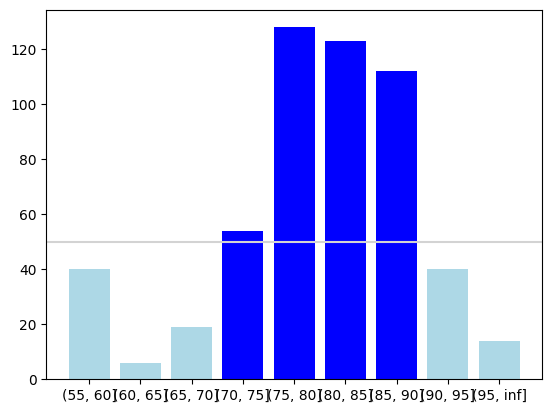

In [87]:
plot_histogram(grade_histogram, error=50, cutoff=50) # TODO: Set error and cutoff correctly.

## `class_year` stats

In [88]:
class_year_mean = context.query().select(
    pl.col("class_year").fill_null(0).dp.mean(bounds=(class_year_min, class_year_max))
).release().collect()
class_year_mean

class_year
f64
1.782313


In [89]:
class_year_histogram = (context.query()
        .group_by("class_year_bin")
        .agg(pl.len().dp.noise())
        .release()
        .collect()
        .sort("class_year_bin")
)
class_year_histogram

class_year_bin,len
str,u32
"""(-inf, 1]""",180
"""(1, 2]""",170
"""(2, 3]""",109
"""(3, inf]""",0


In [90]:
plot_histogram(class_year_histogram, 0)

TypeError: plot_histogram() missing 1 required positional argument: 'cutoff'

At this point, the privacy budget configured at the start with `epsilon` and `weights` is exhausted, and attempting to make another release will result in an error.

---

# Other exports

Below is a proposal for what the other export formats (text and CSV) would look like. We first make a data structure with everything we need, and then use generic methods to serialize that structure.

In [16]:
release = {
    'inputs': {
        'csv_path': csv_path,
        'contributions': contributions,
        'epsilon': epsilon,
        'weights': weights,
        'max_possible_rows': max_possible_rows,
        'delta': delta,
        'grade': {
            'min': grade_min,
            'max': grade_max,
            'bins_count': grade_bins_count,
        },
        'class_year': {
            'min': class_year_min,
            'max': class_year_max,
            'bins_count': class_year_bins_count,
        }    
    },
    'outputs': {
        'grade': {
            'mean': grade_mean.item(),
            'histogram': {v['grade_bin']: v['len'] for v in grade_histogram.to_dicts()}
        },
        'class_year': {
            'mean': class_year_mean.item(),
            'histogram': {v['class_year_bin']: v['len'] for v in class_year_histogram.to_dicts()}
        },
    }
}
release

{'inputs': {'csv_path': '/tmp/demo.csv',
  'contributions': 10,
  'epsilon': 2,
  'weights': [4, 4, 1, 1],
  'max_possible_rows': 1000000,
  'delta': 1e-07,
  'grade': {'min': 50, 'max': 100, 'bins_count': 10},
  'class_year': {'min': 1, 'max': 4, 'bins_count': 4}},
 'outputs': {'grade': {'mean': 82.57369614512471,
   'histogram': {'(55, 60]': 13,
    '(60, 65]': 0,
    '(65, 70]': 1,
    '(70, 75]': 52,
    '(75, 80]': 85,
    '(80, 85]': 97,
    '(85, 90]': 114,
    '(90, 95]': 54,
    '(95, inf]': 44}},
  'class_year': {'mean': 1.784580498866213,
   'histogram': {'(-inf, 1]': 172,
    '(1, 2]': 81,
    '(2, 3]': 118,
    '(3, inf]': 33}}}}

### Text export?

Just use YAML, unless there are other requirements?

In [17]:
import yaml

print(yaml.dump(release))

inputs:
  class_year:
    bins_count: 4
    max: 4
    min: 1
  contributions: 10
  csv_path: /tmp/demo.csv
  delta: 1.0e-07
  epsilon: 2
  grade:
    bins_count: 10
    max: 100
    min: 50
  max_possible_rows: 1000000
  weights:
  - 4
  - 4
  - 1
  - 1
outputs:
  class_year:
    histogram:
      (-inf, 1]: 172
      (1, 2]: 81
      (2, 3]: 118
      (3, inf]: 33
    mean: 1.784580498866213
  grade:
    histogram:
      (55, 60]: 13
      (60, 65]: 0
      (65, 70]: 1
      (70, 75]: 52
      (75, 80]: 85
      (80, 85]: 97
      (85, 90]: 114
      (90, 95]: 54
      (95, inf]: 44
    mean: 82.57369614512471



### CSV export?

Flatten the data stucture to key value pairs and make a two-column CSV unless there are other requirements?

In [18]:
from pandas import json_normalize

json_normalize(release).transpose()

,0
inputs.csv_path,/tmp/demo.csv
inputs.contributions,10
inputs.epsilon,2
inputs.weights,"[4, 4, 1, 1]"
inputs.max_possible_rows,1000000
inputs.delta,0.0
inputs.grade.min,50
inputs.grade.max,100
inputs.grade.bins_count,10
inputs.class_year.min,1
